In [1]:
import numpy as np
import copy
import pickle
import math
import pandas as pd
import matplotlib.pyplot as plt

from stldecompose import decompose, forecast
from stldecompose.forecast_funcs import (naive,drift,mean,seasonal_naive)
#Alternative: from statsmodels.tsa.seasonal import STL

In [2]:
#organized time-series data (using quadtree)
#Fields: ID, Son_ID, TAS(temporal activity signatures), Total_volume, Father_ID, Quadtree_ID
path="D:/input_threescales"
F=open(path,'rb')
inputdata=pickle.load(F)
F.close()
print("Number of spatial units at different scales:",len(inputdata))
print("Length of TAS:",len(inputdata[0][2]))
print("Data sample:",inputdata[0])

Number of spatial units at different scales: 21
Length of TAS: 2208
Data sample: [0, [1, 2, 3, 4], [3225.0, 1813.0, 1298.0, 1288.0, 1693.0, 2807.0, 4849.0, 8873.0, 12048.0, 12382.0, 11652.0, 11535.0, 11338.0, 13105.0, 12964.0, 12217.0, 11391.0, 11188.0, 10104.0, 9097.0, 9311.0, 9376.0, 7979.0, 4826.0, 3787.0, 2307.0, 1593.0, 1186.0, 1528.0, 2735.0, 4745.0, 8686.0, 12622.0, 13193.0, 12387.0, 12127.0, 11765.0, 13096.0, 12785.0, 12183.0, 11566.0, 11305.0, 10204.0, 9459.0, 9436.0, 9844.0, 8273.0, 4923.0, 3903.0, 2398.0, 1619.0, 1208.0, 1631.0, 2946.0, 5002.0, 9148.0, 12980.0, 13647.0, 12700.0, 12702.0, 11944.0, 13660.0, 13078.0, 12421.0, 12180.0, 11825.0, 10911.0, 9731.0, 9964.0, 10101.0, 8565.0, 5122.0, 3947.0, 2402.0, 1630.0, 1192.0, 1491.0, 2941.0, 4798.0, 8645.0, 12272.0, 13062.0, 12589.0, 12416.0, 11783.0, 13053.0, 12754.0, 11909.0, 11405.0, 10927.0, 9808.0, 9123.0, 9622.0, 9594.0, 8455.0, 5219.0, 4056.0, 2475.0, 1638.0, 1240.0, 1621.0, 2945.0, 4739.0, 8911.0, 12814.0, 13446.0, 12663.

In [3]:
#time-series decomposition

#sufficient or not, indensity>1(volume/(km2*hour))
units_num=[1024,256,64]
for i in range(len(inputdata)):
    scale=len(inputdata[i][5])-1
    intensity=inputdata[i][3]*1.0/(units_num[scale]*len(inputdata[0][2]))
    if(intensity>=1):
        inputdata[i].append(1) # sufficient
    else:
        inputdata[i].append(0) # insufficient
        
#decomposition
periods=[24,168]
residuals=[]
for i in range(len(inputdata)):
    tmp_observed=copy.deepcopy(np.array(inputdata[i][2]))
    tmp_residual=np.zeros(len(tmp_observed))
    tmp_trend=np.zeros(len(tmp_observed))
    tmp_periodic=np.zeros(len(tmp_observed))
    tmptag=int(inputdata[i][6]) #sufficient or not
    
    tmpresult=[]
    tmpresult.append(inputdata[i][0]) # ID
    tmpresult.append(inputdata[i][5]) # Quadtree_ID
    tmpresult.append(inputdata[i][2]) # TAS
    tmpresult.append(tmptag)
    #insufficient
    if(tmptag==0):
        tmpresult.append(tmp_periodic)
        tmpresult.append(tmp_trend)
        tmpresult.append(tmp_residual)
        residuals.append(tmpresult)
        continue
    
    #STL
    for j in periods:

        decomp=decompose(tmp_observed,period=j) 
        ## Notice: the original STL code of this study may run error due to the library version issue.
        ## Details please see the url: https://github.com/jrmontag/STLDecompose/issues/17
        #Alternative: decomp=STL(np.array(tmp_observed), period=j).fit()
        
        tmp_periodic+=np.array(decomp.seasonal)
        tmp_trend=copy.deepcopy(np.array(decomp.trend))
        tmp_residual=copy.deepcopy(np.array(decomp.resid))
        #next input
        tmp_observed=tmp_trend+tmp_residual
    
    tmpresult.append(tmp_periodic) #  periodic
    tmpresult.append(tmp_trend) # trend
    tmpresult.append(tmp_residual) # residual
    residuals.append(tmpresult)


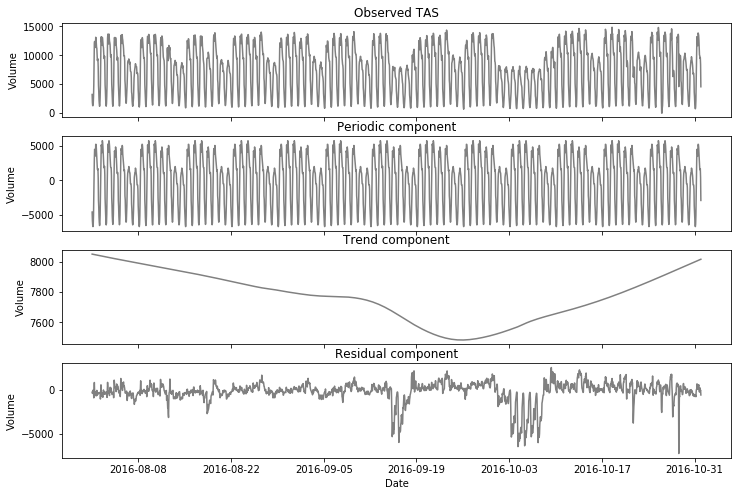

In [4]:
#visualization sample of time-series decomposition
indexlist=pd.date_range(start='2016-08-01',end='2016-11-01',periods=2209)
indexlist=indexlist[:2208]
fig,(AX1,AX2,AX3,AX4) = plt.subplots(4, 1,figsize=(12,8))

AX1.set_ylabel("Volume")
AX1.plot(indexlist,residuals[0][2],color='gray')
AX1.set_title("Observed TAS")
AX1.set_xticklabels([])

AX2.set_ylabel("Volume")
AX2.plot(indexlist,residuals[0][4],color='gray')
AX2.set_title("Periodic component")
AX2.set_xticklabels([])

AX3.set_ylabel("Volume")
AX3.plot(indexlist,residuals[0][5],color='gray')
AX3.set_title("Trend component")
AX3.set_xticklabels([])

AX4.set_ylabel("Volume")
AX4.set_xlabel("Date")
AX4.plot(indexlist,residuals[0][6],color='gray')
AX4.set_title("Residual component")

plt.show()

In [5]:
#detect abnormal time slots

#residuals: ID,Quadtree_ID,TAS,Sufficient,Periodic,Trend,Residual
abnormaltimeslots=[]
for i in range(len(residuals)):
    timeslot=[]
    #insufficient
    if(residuals[i][3]==0):
        abnormaltimeslots.append(timeslot)
        continue
    #Tukey boxplot    
    tmp_timeseries=copy.deepcopy(np.array(residuals[i][6]))
    Q1=np.percentile(tmp_timeseries,25)
    Q3=np.percentile(tmp_timeseries,75)
    IQR=Q3-Q1
    upper=Q3+1.5*IQR
    lower=Q1-1.5*IQR
    for j in range(len(tmp_timeseries)):
        if(tmp_timeseries[j]>upper or tmp_timeseries[j]<lower):
            tmp_outlier=(j,tmp_timeseries[j])
            timeslot.append(tmp_outlier)
    abnormaltimeslots.append(timeslot)


In [6]:
#detect spatio-temporal anomalies
   
#abnormal time slot distribution
#residuals: ID,Quadtree_ID,TAS,Sufficient,Periodic,Trend,Residual
#abnormaltimeslots: Time plot index,Residual value

#abnormal time slot distribution
insufficient_unit=-11111 #tag
unitnum=len(residuals)
timeslotnum=len(residuals[0][2])
ats_distribution=np.zeros((unitnum,timeslotnum),dtype=np.float)

for i in range(unitnum):
    tmptag=int(residuals[i][3]) 
    if(tmptag==0): # insufficient
        for j in range(timeslotnum):
            ats_distribution[i][j]=insufficient_unit #tag
        continue
    for j in range(len(abnormaltimeslots[i])):
        tsindex=abnormaltimeslots[i][j][0]
        tsvalue=abnormaltimeslots[i][j][1]
        ats_distribution[i][tsindex]=tsvalue

#three dimensional organization (spatial: X,Y; temporal: Z)
distributiondata=np.array(ats_distribution)
scale1=distributiondata[0:1]
scale2=distributiondata[1:5]
scale3=distributiondata[5:21]

scale1=scale1.reshape(1,1,2208)
scale2=scale2.reshape(2,2,2208)
scale3=scale3.reshape(4,4,2208)

#detect anomalies using SRG
def anomalydetection(three_d_data):
    xnum=len(three_d_data)
    ynum=len(three_d_data[0])
    znum=len(three_d_data[0][0])
    tags=np.zeros((xnum,ynum,znum))
    classlabel=0
    tmpstack=[]
    
    #neighbor form
    processing=[(1,0,0),(1,-1,0),(0,-1,0),(-1,-1,0),(-1,0,0),(-1,1,0),(0,1,0),(1,1,0),
            (1,0,1),(1,-1,1),(0,-1,1),(-1,-1,1),(-1,0,1),(-1,1,1),(0,1,1),(1,1,1),(0,0,1),
            (1,0,-1),(1,-1,-1),(0,-1,-1),(-1,-1,-1),(-1,0,-1),(-1,1,-1),(0,1,-1),(1,1,-1),(0,0,-1)
           ]
    
    for i in range(xnum):
        for j in range(ynum):
            for k in range(znum):
                tmpunit=three_d_data[i][j][k]
                if(tmpunit!=-11111 and tmpunit!=0 and tags[i][j][k]==0):
                    classlabel+=1
                    tags[i][j][k]=classlabel
                    tmpstack.append((i,j,k))
                    while(len(tmpstack)>0):
                        tmp=tmpstack.pop()
                        x=int(tmp[0])
                        y=int(tmp[1])
                        z=int(tmp[2])
                        for n in processing:
                            t_x=x+n[0]
                            t_y=y+n[1]
                            t_z=z+n[2]
                            if(t_x>=0 and t_y>=0 and t_z>=0 and t_x<xnum and t_y<ynum and t_z<znum):
                                if(tags[t_x][t_y][t_z]==0 and three_d_data[t_x][t_y][t_z]!=-11111 and three_d_data[t_x][t_y][t_z]!=0):
                                    tags[t_x][t_y][t_z]=classlabel
                                    tmpstack.append((t_x,t_y,t_z))
                                
                    
    anomalylist=[]
    anum=int(np.max(np.reshape(tags,(xnum*ynum*znum,1))))
    for i in range(anum):
        tmp=[]
        anomalylist.append(tmp)
    for i in range(xnum):
        for j in range(ynum):
            for k in range(znum):
                if(tags[i][j][k]!=0):
                    anomalylist[int(tags[i][j][k])-1].append((i,j,k,three_d_data[i][j][k]))
    return anomalylist

anomalies1=anomalydetection(copy.deepcopy(scale1))
anomalies2=anomalydetection(copy.deepcopy(scale2))
anomalies3=anomalydetection(copy.deepcopy(scale3))

print("Number of anomalies detected at scale 1:",len(anomalies1))
print("Number of anomalies detected at scale 2:",len(anomalies2))
print("Number of anomalies detected at scale 3:",len(anomalies3))

Number of anomalies detected at scale 1: 41
Number of anomalies detected at scale 2: 81
Number of anomalies detected at scale 3: 290


In [7]:
#anomaly matching

#return anomaly characteristics: Spatial influence range, Temporal influence range, Influence volume, Influence intensity
def getanomalyinformation(tmpanomaly,unitnum):
    N=len(tmpanomaly)
    spatial=[]
    temporal=[]
    total=0
    for i in range(N):
        tmpvolume=float(tmpanomaly[i][3])
        total+=tmpvolume
        temporal.append(int(tmpanomaly[i][2]))
        x=int(tmpanomaly[i][0])
        y=int(tmpanomaly[i][1])
        length=int(math.sqrt(unitnum))
        tmpspatial=x*length+y
        if(tmpspatial in spatial):
            continue
        spatial.append(tmpspatial)
    result=[]
    result.append(spatial)
    t_min=min(temporal)
    t_max=max(temporal)
    result.append((t_min,t_max))
    result.append(total)
    density=(total*unitnum)/(N*1024)
    result.append(density)
    return result

#get anomaly characteristics
anomalyinformation_S1=[]
for i in range(len(anomalies1)):
    tmp=getanomalyinformation(anomalies1[i],1)
    anomalyinformation_S1.append(tmp)

anomalyinformation_S2=[]
for i in range(len(anomalies2)):
    tmp=getanomalyinformation(anomalies2[i],4)
    anomalyinformation_S2.append(tmp)

anomalyinformation_S3=[]
for i in range(len(anomalies3)):
    tmp=getanomalyinformation(anomalies3[i],16)
    anomalyinformation_S3.append(tmp)
    
#overlap ratio of influence range
#index: 
#scale1:0; scale2:0+1=1; scale3: 0+1+4=5
def judgematch(coarseanomaly, fineanomaly, threshold,fatherindex,sonindex):
    #temporal
    min1=coarseanomaly[1][0]
    max1=coarseanomaly[1][1]
    min2=fineanomaly[1][0]
    max2=fineanomaly[1][1]
    length2=max2-min2+1
    temporal=0
    if(min2>=min1 and max2<=max1):
        temporal=1
    else:
        t_overlap=0
        for i in range(length2):
            tmp=min2+i
            if(tmp>=min1 and tmp<=max1):
                t_overlap+=1
        temporal=t_overlap*1.0/length2
    #spatial
    fatherset=[]
    for i in range(len(coarseanomaly[0])):
        fatherset.append(coarseanomaly[0][i]+fatherindex)
    N=len(fineanomaly[0])
    s_overlap=0
    for i in range(N):
        newid=fineanomaly[0][i]+sonindex
        fatherid=int(inputdata[newid][4])
        if(fatherid in fatherset):
            s_overlap+=1
    spatial=s_overlap*1.0/N
    
    result=temporal*spatial
    if(result>=threshold):
        return 1
    else:
        return 0   

#matching relationship

matched_son=[[],[]] #scales: 1,2
matched_father=[[],[]] #scales: 2,3
for i in range(len(anomalies1)):
    tmp=[]
    matched_son[0].append(tmp)
for i in range(len(anomalies2)):
    tmp1=[]
    tmp2=[]
    matched_son[1].append(tmp1)
    matched_father[0].append(tmp2)
for i in range(len(anomalies3)):
    tmp=[]
    matched_father[1].append(tmp)

threshold_value=0.64

for i in range(len(anomalyinformation_S1)):
    tmp_f=copy.deepcopy(anomalyinformation_S1[i])
    for j in range(len(anomalyinformation_S2)):
        tmp_s=copy.deepcopy(anomalyinformation_S2[j])
        result=judgematch(tmp_f,tmp_s,threshold_value,0,1)
        if(result==1):
            matched_son[0][i].append(j)
            matched_father[0][j].append(i)  

for i in range(len(anomalyinformation_S2)):
    tmp_f=copy.deepcopy(anomalyinformation_S2[i])
    for j in range(len(anomalyinformation_S3)):
        tmp_s=copy.deepcopy(anomalyinformation_S3[j])
        result=judgematch(tmp_f,tmp_s,threshold_value,1,5)
        if(result==1):
            matched_son[1][i].append(j)
            matched_father[1][j].append(i)


In [8]:
#matching relationship sample
#For instance, the third anomaly at Scale 1 has been matched with the kth anomaly at Scale 2, k=matched_son[0][2]
print("Scale 1 anomalies' matched anomalies (IDs) at Scale 2:\n",matched_son[0],"\n")
print("Scale 2 anomalies' matched anomalies (IDs) at Scale 3:\n",matched_son[1],"\n")
print("Scale 2 anomalies' matched anomalies (IDs) at Scale 1:\n",matched_father[0],"\n")

Scale 1 anomalies' matched anomalies (IDs) at Scale 2:
 [[], [], [1], [43], [4], [5], [], [7], [], [9], [10], [47], [11], [12], [14], [], [], [16], [], [], [23], [24], [25], [26], [27], [28], [29], [30], [], [31], [49], [32], [50], [], [], [36], [38], [], [], [40], [41]] 

Scale 2 anomalies' matched anomalies (IDs) at Scale 3:
 [[49, 124], [4], [], [], [10], [11], [12], [112, 204], [113], [60, 254], [], [17], [], [], [], [20], [], [], [], [], [179, 266], [], [], [27], [28], [29], [30], [31], [32], [], [], [35, 276], [36], [], [], [], [], [40], [41], [], [], [44], [], [], [], [], [59], [259], [], [], [83], [], [130], [133], [], [], [149], [214], [], [], [231], [], [158], [249], [154], [], [], [], [263], [273], [274], [], [283], [], [], [], [], [], [], [189], []] 

Scale 2 anomalies' matched anomalies (IDs) at Scale 1:
 [[], [2], [], [], [4], [5], [], [7], [], [9], [10], [12], [13], [], [14], [], [17], [], [], [], [], [], [], [20], [21], [22], [23], [24], [25], [26], [27], [29], [31], []